In [1]:
# Ensure you have the following installed:
# numpy
# os
# compas
# compas_fd
# warnings
# traceback
# pickle

# Install by running:
# !pip install -r requirements.txt

In [2]:
import numpy as np
import pickle
import pandas as pd

# G-code generation codes are cloned from https://github.com/tibor-barsi/GcodeGenerator. Tibor Barsi is the author of the code, and was a PhD student at the Ladisk lab of the University of Ljubljana
#  We should be careful with crediting the author of the code, if we ever want to make these code public.
from src.g_code_generation_copy.gcode_generator import G_code_generator
from src.g_code_generation_copy.tool_changer_functions import save_params, load_params, printer_start, load_tool, unload_tool, tool_change, take_photo, play_sound, printer_stop
# from src.additional_functions import *
from src.network import Network_custom, replace_brackets
import os

BYU_UW_root = r"G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Research Projects\Spiders\BYU-UW"

### Step 1: Define the network

In [3]:
# Note that the coordinates of the vertices will change after equilibrium is reached.
vertices    = np.array([[-10, 0, 0], [-5, 0,0], [5, 0, 0], [10, 0, 0], [0,-10,0], [0,-5,0], [0,5,0], [0,10,0]])*10.5  # The coordinates of the vertices in mm
edges       = [[0, 1], [1, 5], [5, 2], [2, 3], [4, 5], [5, 6], [6,7], [1, 6], [6, 2]]                  # The edges of the network.
paths       = [[0, 1, 2, 3], [4, 5, 6], [7, 8]]   # 3D printable paths. Ensure an edge is not flipped.
directions  = [1, 1, 1, 1, 1, 1, 1, 1, 1]          # Flip the curvature of an edge by setting the direction to -1.

scalar = 110
q_ring      = .5
q_connectors = .8
q_center    = .2
q           = np.array([q_connectors, q_ring, q_ring, q_connectors, q_connectors, q_center, q_connectors, q_ring, q_ring])/scalar
# q[2]        = 1.5/scalar
# q[-1]        = 1.5/scalar
fixed       = [0, 3, 4, 7]
# model_name  = 'VS_ring{}_connectors{}_center{}_as{}'.format(q_ring, q_connectors, q_center, q[2]*scalar)
# model_name  = 'VS_ring{}_connectors{}_center{}_as{}_asr{}_s{}'.format(q_ring, q_connectors, q_center, q[2]*scalar, q[-1]*scalar, scalar)
model_name  = 'unit_cell'

# Create the network
net = Network_custom.from_fd(vertices, edges, q, fixed, paths = paths, dir = directions)

# The topology of structure is fixed after generation, but you can update force densities after making the network
# q[0] = .10
# net.update_shape(q)

# Plot the network like this
net.net_plot(color=True, elables = True, vlabels = False)

(net.vertices == vertices).all() # Please understand that this is False
np.max(net.f)/0.078294515

# import matplotlib.pyplot as plt
# cmap = plt.get_cmap('viridis')

# Convert to TikZ RGB format
# f_plot = (net.f - np.min(net.f)) / (np.max(net.f) - np.min(net.f))
# for val in f_plot:
#     r, g, b, _ = cmap(val)  # Get RGBA (ignore A)color={rgb,1:red,0.282;green,0.141;blue,0.458}
#     print("\draw[thick, color = {" + f"rgb,1:red,{r:.3f}; green,{g:.3f};blue, {b:.3f}"+"}]")

np.max(net.f)/0.078294515

6.206698045490677

In [4]:
def R(theta):
    """
    Rotation matrix around the z-axis
    :param theta: angle in radians
    :return: rotation matrix
    """
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

# Note that the coordinates of the vertices will change after equilibrium is reached.
L_scale = 10
vertices    = np.array([[-10, 0, 0], [-5, 0,0], [0, 0, 0], [5, 0, 0], [10, 0, 0], [0,-10,0], [0,-5,0], [0,5,0], [0,10,0]])*L_scale  # The coordinates of the vertices in mm
vertices    = vertices@R(np.pi/4)
edges       = [[0, 1], [1, 2], [2, 3], [3, 4], [5, 6], [6, 2], [2, 7], [7, 8], [1, 6], [6, 3], [3, 7], [7,1]]                  # The edges of the network.
paths       = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]]   # 3D printable paths. Ensure an edge is not flipped.
directions  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]          # Flip the curvature of an edge by setting the direction to -1.
center_cross_path = [1, 2, 5, 6]
connector_path = [0, 3, 4, 7]
q_scalar = 1.4
sum_q0 = 0.02*q_scalar
sum_q1 = 0.02*q_scalar
sum_q2 = 0.01*q_scalar
offset = 1/64
ratio_0 = np.array([3/8-offset, 1/8, 1/8, 3/8+offset])
ratio_1 = np.array([3/8, 1/8-offset, 1/8+offset, 3/8])
ratio_2 = np.array([2/8-offset, 2/8+offset, 2/8, 2/8])

q = np.zeros(len(edges))
q[paths[0]] = sum_q0*ratio_0
q[paths[1]] = sum_q1*ratio_1
q[paths[2]] = sum_q2*ratio_2

fixed       = [0, 4, 5, 8]
# Create the network
net = Network_custom.from_fd(vertices, edges, q, fixed, paths = paths, dir = directions)
net.net_plot(color=True, elables = True, vlabels = False)
np.max(net.f)/0.078294515
vertices

array([[-70.71067812,  70.71067812,   0.        ],
       [-33.93849511,  35.28118005,   0.        ],
       [  2.93490296,   1.50737677,   0.        ],
       [ 35.98777313, -36.16832038,   0.        ],
       [ 70.71067812, -70.71067812,   0.        ],
       [-70.71067812, -70.71067812,   0.        ],
       [-34.57775736, -36.79418107,   0.        ],
       [ 35.50744134,  34.76582741,   0.        ],
       [ 70.71067812,  70.71067812,   0.        ]])

In [5]:
file_path = os.path.join(BYU_UW_root, 'Tensile Testing', 'Avg_Stress_Strain_Overture_TPU.csv')
stress_data, strain_data = net.load_stress_strain_curve(file_path)
TPU_nl = {'stress':strain_data, 'strain': stress_data, 'v':0.3897, 'p':1.18e-9, 'A': 0.078294515, 'name': 'TPU Overture'} # TPU Overture non-conductive
A = [TPU_nl['A']]*len(net.edges)
l0, l_scalar = net.materialize_nonlinear(A, stress_data, strain_data, interpolation_kind = 'cubic')
strain_to_stress = net.material_model(stress_data, strain_data, interpolation_kind = 'cubic')

In [6]:
# vertices = net.vertices.copy()*1.1
vertices_equilibrium, l1, f = net.find_equilibrium(vertices, A, strain_to_stress)
# net.net_plot(color=False, elables = True, vlabels = False, custom_vertices = vertices_equilibrium)
# f/A

Constant settings

In [7]:
printing_params = load_params(r'DATA/NT_Eel_0.2mm_og.json')
alpha_loop = np.deg2rad(30) # The angle of the loop
L_loop  = 9                # The length of the loop
n_points = 20               # The number of points in the loop

start_gcode     = open(r'DATA/start_gcode.gcode', 'r').read()
end_gcode       = open(r'DATA/end_gcode.gcode', 'r').read()

temperature_settings = {'first_layer_bed_temperature': 65, 'first_layer_temperature':205, 'K-factor': 0.20}
comment = ''

bed_width = 230
bed_height = 210

start_loop_bools = [True, True, False]
end_loop_bools = [True, True, False]

running_start_bools = [False, True, True]
running_end_bools = [False, False, False]
L_running = 2

file_path = os.path.join(BYU_UW_root, 'Tensile Testing', 'Avg_Stress_Strain_Overture_TPU_1mm2.csv')
stress_data, strain_data = net.load_stress_strain_curve(file_path, A_scale = 1.0)

TPU_nl = {'stress':strain_data, 'strain': stress_data, 'v':0.3897, 'p':1.18e-9, 'A': 0.078294515, 'name': 'TPU Overture'} # TPU Overture non-conductive

A = [TPU_nl['A']]*len(net.edges)

# Purge line coors
gen = G_code_generator(printing_params)
point0, point1 = [20,15,0.3], [90,15,0.3]
point2, point3 = [90,10,0.3], [20,10,0.3]

def make_purge_line(g_code, printing_params, gen, point0, point1, ef_extra = 1.0, comment=''):
    """"
    ""Make a purge line at the start of the print."
    """
    g_code += gen.move_to_point(point0[0:2], point0[2] + printing_params['nozzle_lift'], comment='Move to start point')
    g_code += gen.move_to_point(point0[0:2], point0[2], comment='Lower Nozzle')
    g_code += gen.unretract()
    g_code += gen._print_line(
            point0=point0,
            point1=point1,
            move_to_start=False, # move to start point without extruding
            extrude_factor=printing_params['extrude_factor']*ef_extra,
            comment=comment)
    g_code += gen.retract()
    g_code += gen.wipe(2 * np.pi)
    return g_code

def add_net_to_gcode(g_code, printing_params, gen, net):
    for path_i, cor_list in enumerate(net.paths_xyz):
        g_code += '\n;Path (' + str(path_i) + ' ' + str(path_i) + ')\n'
        cor_list   = np.array(cor_list)
        # Move the coordinates to the center of the bed and add the layer height
        cor_list[:,0] += bed_width/2 -14
        cor_list[:,1] += bed_height/2 
        cor_list[:,2] += printing_params['layer_height']
        g_code += '\n'
        # Move the coordinates to the start point
        g_code += gen.move_to_point(cor_list[0][0:2], cor_list[0][2] + printing_params['nozzle_lift'], comment='Move to start point')
        # Lower the nozzle
        g_code += gen.move_to_point(cor_list[0][0:2], cor_list[0][2], comment='Lower Nozzle')
        # Unretract the filament
        g_code += gen.unretract()
        # Print the path
        for point0, point1 in zip(cor_list[:-1], cor_list[1:]):
                g_code += gen._print_line(
                point0=point0,
                point1=point1,
                move_to_start=False, # move to start point without extruding
                extrude_factor = printing_params['extrude_factor'],
                comment=comment)
        # Retract the filament
        g_code += gen.retract()
        # Wipe the nozzle
        g_code += gen.wipe_from_last_points(g_code)    
        # Raise the nozzle
        g_code += gen.move_to_point(point1[0:2], point1[2] + printing_params['nozzle_lift'], speed_factor=0.5, comment='Raise Nozzle')
    return g_code

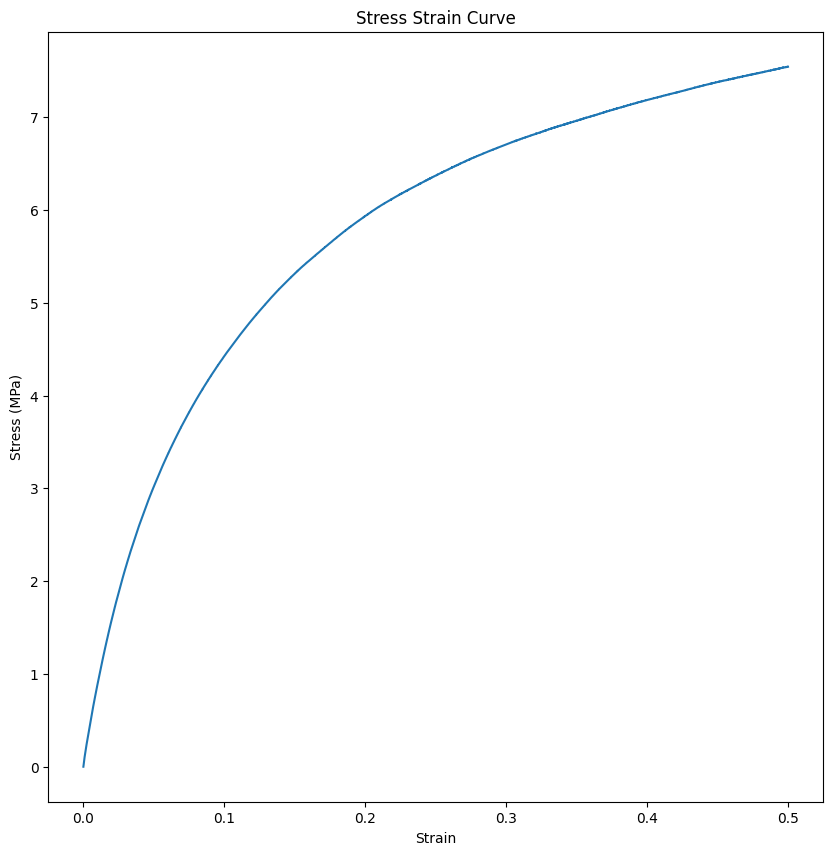

In [8]:
import matplotlib.pyplot as plt
fix, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title('Stress Strain Curve')
ax.set_xlabel('Strain')
ax.set_ylabel('Stress (MPa)')
ax.plot(strain_data, stress_data, label='Stress Strain Curve')

Generate 4 specimens only changing the tension

In [9]:
q0 = q.copy()
q_scalars = [0.35, 0.6, 0.8, 1.0]
for q_scalar in q_scalars:
    q_new = q0*q_scalar
    # net.update_shape(q_new)
    net = Network_custom.from_fd(vertices, edges, q_new, fixed, paths = paths, dir = directions)
    l1_initial = net.l1.copy()
    l0, l_scalar = net.materialize_nonlinear(A, stress_data, strain_data, interpolation_kind = 'cubic')
    net.initialize_shape_optimizer(function_type = 'standard',  method = 'Gauss-Seidel',options ={"maxiter": 1000, "damping": .01, "correction_scalar": 1., "tol": 1e-6})
    # net.initialize_shape_optimizer(function_type = 'standard',  method = 'L-BFGS-B',options ={"maxiter": 10000, "maxfun": 1500000, "maxls": 5000})
    net.optimize_vertices()
    reference_point = [0,0,0]                         # The network will be scaler relative to this point
    net.scale_vertices(reference_point, net.l_scalar, account_for_leafs = True) # If you don't provide a scalar, it will use network.l_scalar automatically
    R, th = net.arc_param()
    xyz = net.arc_points(n = 10)
    net.auto_flip_curves(n = 10)        # Automatically flip the curvature of the edges. Directions will become 1, -1, 1, -1, ...
    net.flip_curves()                   # Flip all the edges.
    net.flip_curves([2, 5, 8], n = 10)
    net.jump_at_intersection(intersection_width = printing_params['d_nozzle']*1.5, intersection_height = printing_params['layer_height'], interpolation_function=None) 
    net.net_plot(color=True, plot_type='arcs', elables=True, vlabels = True)
    net.all_loop_to_path(start_loop_bools, end_loop_bools, L_loop, alpha_loop, n_points)
    net.add_running_start(running_start_bools, running_end_bools, L_running, n_points)
    file_name = model_name + f'_even_q_{q_scalar}_{L_scale}'
    net.save_network(os.path.join(BYU_UW_root, 'networks', file_name + '.pkl'))
    print(f"q_scalar: {q_scalar}, l_scalar: {l_scalar}, max stress: {np.max(net.f)/TPU_nl['A']}")

    g_code = replace_brackets(start_gcode, temperature_settings)
    g_code += make_purge_line(g_code, printing_params, gen, point0, point1, comment='Purge line', ef_extra=2.5)
    g_code += make_purge_line(g_code, printing_params, gen, point2, point3, comment='Purge line', ef_extra=1.0)
    g_code += add_net_to_gcode(g_code, printing_params, gen, net)

    g_code += end_gcode
    with open(os.path.join('DATA', 'generated_gcodes', model_name + file_name + '.gcode'), "w") as g_code_file:
        g_code_file.write(g_code)
    print(model_name + f'_even_q_{q_scalar}.gcode', ((net.R * net.th) - net.l0))
    

Iteration 0: Current error = 14.701732181620766
Iteration 100: Current error = 7.17330991817997
Iteration 200: Current error = 3.5850913165590814
Iteration 300: Current error = 1.8278808428898348
Iteration 400: Current error = 0.9636750035003154
Iteration 500: Current error = 0.5374970715890869
Iteration 600: Current error = 0.3269239047021964
Iteration 700: Current error = 0.2227424338685518
Iteration 800: Current error = 0.1711563997391281
Iteration 900: Current error = 0.14560113793307294
Final error: 0.13302657516976685


q_scalar: 0.35, l_scalar: 0.9661476986339055, max stress: 2.3947309968062718
unit_cell_even_q_0.35.gcode [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 0: Current error = 72.34953760167103
Iteration 100: Current error = 33.80612332184265
Iteration 200: Current error = 16.65082082687943
Iteration 300: Current error = 8.388772747251169
Iteration 400: Current error = 4.372404440121662
Iteration 500: Current error = 2.4079112891146806
Iteration 600: Current error = 1.4429216779243923
Iteration 700: Current error = 0.9674811918287529
Iteration 800: Current error = 0.7328367665933253
Iteration 900: Current error = 0.616892697992467
Final error: 0.5599754927187394


q_scalar: 0.6, l_scalar: 0.9207846243524951, max stress: 4.105253137382181
unit_cell_even_q_0.6.gcode [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 0: Current error = 206.36534532260927
Iteration 100: Current error = 91.21874959416428
Iteration 200: Current error = 44.16059630336394
Iteration 300: Current error = 21.96308794420702
Iteration 400: Current error = 11.330465760103213
Iteration 500: Current error = 6.183839752451774
Iteration 600: Current error = 3.674597152532671
Iteration 700: Current error = 2.4449026324474428
Iteration 800: Current error = 1.8404087995023524
Iteration 900: Current error = 1.5426670726237321
Final error: 1.3968781470533436


q_scalar: 0.8, l_scalar: 0.8609101575214607, max stress: 5.4736708498429065
unit_cell_even_q_0.8.gcode [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.10542736e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Iteration 0: Current error = 583.8798906761073
Iteration 100: Current error = 234.86944297995535
Iteration 200: Current error = 110.31576080546049
Iteration 300: Current error = 53.629796945833256
Iteration 400: Current error = 27.17108525742677
Iteration 500: Current error = 14.593804421311901
Iteration 600: Current error = 8.538780660974997
Iteration 700: Current error = 5.598535052866643
Iteration 800: Current error = 4.162882398005684
Iteration 900: Current error = 3.459388176686685
Final error: 3.1163130770817613


q_scalar: 1.0, l_scalar: 0.7545656668109403, max stress: 6.8420885623036325
unit_cell_even_q_1.0.gcode [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Generate specimens making inner part iteratively smaller

In [10]:
q0 = q.copy()
q_scalars_connector = [.7, .6, .4, .35]
q_scalars_ring = [ 1.5, 4, 6, 13]
q_scalars_cross = [2, 3, 5, 14]
for q_scalar_ring, q_scalar_cross, q_scalar_connector in zip(q_scalars_ring, q_scalars_cross, q_scalars_connector):
    q_new = q0.copy()
    q_new[paths[2]]*= q_scalar_ring
    q_new[center_cross_path] *= q_scalar_cross
    q_new[connector_path] *= q_scalar_connector
    # net.update_shape(q_new)
    net = Network_custom.from_fd(vertices, edges, q_new, fixed, paths = paths, dir = directions)
    net.net_plot(color=True, elables = False, vlabels = True)
    l0, l_scalar = net.materialize_nonlinear(A, stress_data, strain_data, interpolation_kind = 'cubic')
    net.initialize_shape_optimizer(function_type = 'standard',  method = 'Gauss-Seidel',options ={"maxiter": 100000, "damping": .1, "correction_scalar": 1.0, "tol": 1e-6})
    # net.initialize_shape_optimizer(function_type = 'standard',  method = 'L-BFGS-B',options ={"maxiter": 10000, "maxfun": 1500000, "maxls": 5000})
    net.optimize_vertices()
    reference_point = [0,0,0]                         # The network will be scaler relative to this point
    net.scale_vertices(reference_point, net.l_scalar, account_for_leafs = True) # If you don't provide a scalar, it will use network.l_scalar automatically
    R, th = net.arc_param()
    xyz = net.arc_points(n = 10)
    net.auto_flip_curves(n = 10)        # Automatically flip the curvature of the edges. Directions will become 1, -1, 1, -1, ...
    net.flip_curves()                   # Flip all the edges.
    net.flip_curves([2, 5, 8], n = 10)
    net.jump_at_intersection(intersection_width = printing_params['d_nozzle']*1.5, intersection_height = printing_params['layer_height'], interpolation_function=None) 
    net.net_plot(color=True, plot_type='arcs', elables=True, vlabels = True)
    net.all_loop_to_path(start_loop_bools, end_loop_bools, L_loop, alpha_loop, n_points)
    net.add_running_start(running_start_bools, running_end_bools, L_running, n_points)
    file_name = model_name + f'_loop_size_q_{q_scalar_ring, q_scalar_cross, q_scalar_connector}_{L_scale}'
    net.save_network(os.path.join(BYU_UW_root, 'networks', file_name + '.pkl'))
    print(f"l_scalar: {l_scalar}, max stress: {np.max(net.f)/TPU_nl['A']}")

    g_code = replace_brackets(start_gcode, temperature_settings)
    g_code += make_purge_line(g_code, printing_params, gen, point0, point1, comment='Purge line', ef_extra=2.5)
    g_code += make_purge_line(g_code, printing_params, gen, point2, point3, comment='Purge line', ef_extra=1.0)
    g_code += add_net_to_gcode(g_code, printing_params, gen, net)

    g_code += end_gcode
    with open(os.path.join('DATA', 'generated_gcodes', model_name + file_name + '.gcode'), "w") as g_code_file:
        g_code_file.write(g_code)
    print(model_name + f'_loop_size_q_{q_scalar_ring, q_scalar_cross, q_scalar_connector}.gcode',((net.R * net.th) - net.l0))

Iteration 0: Current error = 791.3709782440583
Iteration 100: Current error = 0.33968191017424026
Iteration 200: Current error = 0.03238741959201005
Converged after 218 iterations.
Final error: 0.03225302471996146


l_scalar: 0.7656427584870702, max stress: 6.74180352102805
unit_cell_loop_size_q_(1.5, 2, 0.7).gcode [0.00000000e+00 3.55271368e-15 0.00000000e+00 0.00000000e+00
 7.10542736e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


Iteration 0: Current error = 1514.0305565773406
Iteration 100: Current error = 1.1786829471919527
Iteration 200: Current error = 0.7347891647483205
Converged after 287 iterations.
Final error: 0.7341795000713762


l_scalar: 0.7261211593361019, max stress: 7.054808258591899
unit_cell_loop_size_q_(4, 3, 0.6).gcode [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Iteration 0: Current error = 379.03983377154384
Iteration 100: Current error = 0.16850447137506702
Iteration 200: Current error = 0.0377780036925296
Converged after 214 iterations.
Final error: 0.03774273998192629


l_scalar: 0.8797869336166507, max stress: 5.111162923228804
unit_cell_loop_size_q_(6, 5, 0.4).gcode [0.0000000e+00 8.8817842e-16 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


Iteration 0: Current error = 287.702301965458
Iteration 100: Current error = 0.08490593697368938
Iteration 200: Current error = 0.0013014443257111583
Converged after 218 iterations.
Final error: 0.0012621230996222963


l_scalar: 0.899527282765435, max stress: 4.665119292748729
unit_cell_loop_size_q_(13, 14, 0.35).gcode [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Build figures:

unit_cell_even_q_0.35.pkl
unit_cell_even_q_0.6.pkl
unit_cell_even_q_1.0.pkl
unit_cell_loop_size_q_(4, 3, 0.6).pkl
unit_cell_loop_size_q_(13, 14, 0.35).pkl
unit_cell_loop_size_q_(6, 5, 0.4).pkl
unit_cell_even_q_0.8.pkl
unit_cell_loop_size_q_(1.5, 2, 0.7).pkl
unit_cell_even_q_0.35_10.pkl
unit_cell_even_q_0.6_10.pkl
unit_cell_even_q_0.8_10.pkl
unit_cell_even_q_1.0_10.pkl
unit_cell_loop_size_q_(1.5, 2, 0.7)_10.pkl
unit_cell_loop_size_q_(4, 3, 0.6)_10.pkl
unit_cell_loop_size_q_(6, 5, 0.4)_10.pkl
unit_cell_loop_size_q_(13, 14, 0.35)_10.pkl


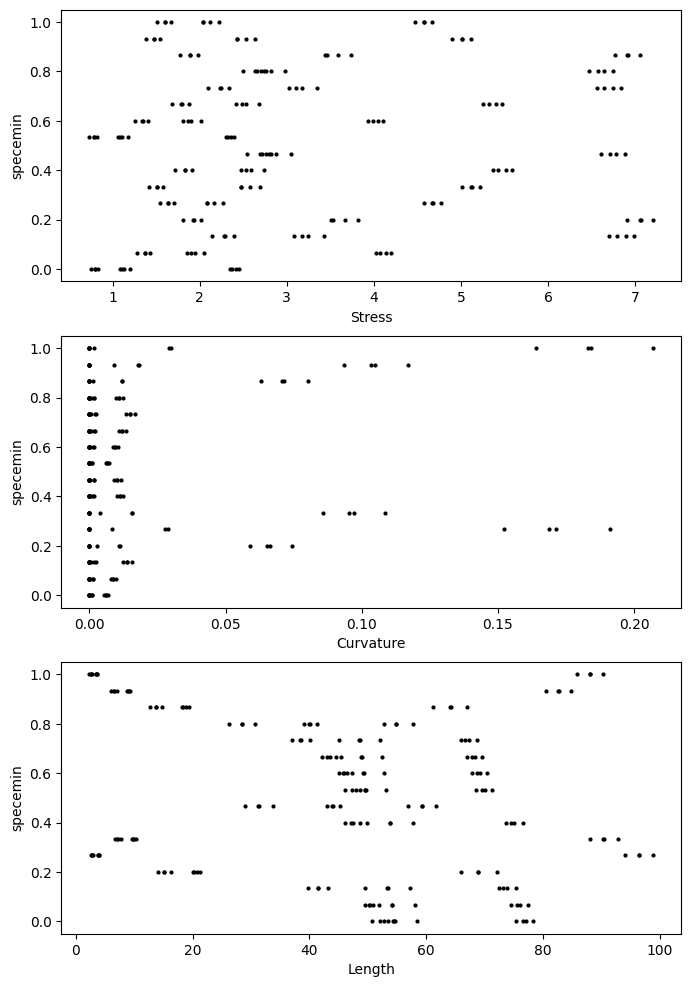

In [11]:
import matplotlib.pyplot as plt
net_path = os.path.join(BYU_UW_root, 'networks')
net_files = os.listdir(net_path)
filtered_files = [file for file in net_files if file.startswith(model_name)]

temp_error_all = np.linspace(0, 1, len(filtered_files))

ystring = 'specemin'

fig, ax = plt.subplots(3,1, figsize=(8, 12))
ax[0].set_xlabel('Stress')
ax[0].set_ylabel(ystring)
ax[1].set_xlabel('Curvature')
ax[1].set_ylabel(ystring)
ax[2].set_xlabel('Length')
ax[2].set_ylabel(ystring)

for net_file, temp_error in zip(filtered_files, temp_error_all):
    print(net_file)
    with open(os.path.join(net_path, net_file), 'rb') as f:
        net = pickle.load(f)
    for edge, fi, l0i, Ri in zip(net.edges, net.f, net.l0, net.R):
        kappai = 1/Ri
        ax[0].plot(fi/TPU_nl['A'], temp_error, 'o', color='black', markersize=2)
        ax[1].plot(kappai, temp_error, 'o', color='black', markersize=2)
        ax[2].plot(l0i, temp_error, 'o', color='black', markersize=2)

In [12]:
# for edge_i, edge in enumerate(net.edges): (-3.13, 0.987) arc (239.60: 277.368:8.4696);
#     v0, v1 = edge
#     coor0, coor1 = net.vertices[v0], net.vertices[v1]
#     print(f'{edge_i}, starts at {coor0}, ends at {coor1}, and has a radius of {net.R[edge_i]} and an angle of {net.th[edge_i]}')
for edge_i, edge in enumerate(net.edges):
    v0, v1 = edge
    coor0, coor1 = net.vertices[v0], net.vertices[v1]
    R, th = net.R[edge_i], net.th[edge_i]
    center, theta0, theta1 = net._points_on_arc(coor0[:2], coor1[:2], R, print_parameters = True)
    # print(coor0[:2]/10, theta0*180/np.pi, theta1*180/np.pi, R)
    if R/10 > 10000:
        print(f"\draw ({coor0[0]/10:.3f}, {coor0[1]/10:.3f}) -- ({coor1[0]/10:.3f}, {coor1[1]/10:.3f});")
        continue
    if theta0 > theta1:
        print(f"\draw ({coor1[0]/10:.3f}, {coor1[1]/10:.3f}) arc ({theta0*180/np.pi:.3f}:{theta1*180/np.pi:.3f}:{-R/10:.3f});")
    else:
        print(f"\draw ({coor0[0]/10:.3f}, {coor0[1]/10:.3f}) arc ({theta0*180/np.pi:.3f}:{theta1*180/np.pi:.3f}:{R/10:.3f});")

\draw (-7.071, 7.071) -- (-0.031, 0.043);
\draw (-0.031, 0.043) arc (213.051:240.273:0.543);
\draw (0.155, -0.132) arc (207.435:234.587:0.547);
\draw (0.323, -0.326) -- (7.071, -7.071);
\draw (-7.071, -7.071) -- (-0.037, -0.331);
\draw (-0.037, -0.331) arc (303.033:329.197:0.610);
\draw (0.155, -0.132) arc (301.933:330.371:0.483);
\draw (0.319, 0.039) -- (7.071, 7.071);
\draw (-0.031, 0.043) arc (175.976:182.281:3.404);
\draw (-0.037, -0.331) arc (267.792:273.942:3.355);
\draw (0.323, -0.326) -- (0.319, 0.039);
\draw (0.319, 0.039) arc (89.145:89.490:58.198);


<>:12: SyntaxWarning:

invalid escape sequence '\d'

<>:15: SyntaxWarning:

invalid escape sequence '\d'

<>:17: SyntaxWarning:

invalid escape sequence '\d'

<>:12: SyntaxWarning:

invalid escape sequence '\d'

<>:15: SyntaxWarning:

invalid escape sequence '\d'

<>:17: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\thijs\AppData\Local\Temp\ipykernel_30956\621585458.py:12: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\thijs\AppData\Local\Temp\ipykernel_30956\621585458.py:15: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\thijs\AppData\Local\Temp\ipykernel_30956\621585458.py:17: SyntaxWarning:

invalid escape sequence '\d'



Make the paths

In [13]:
minx, miny = 90, 90
maxx, maxy = 0, 0
for path_i, cor_list in enumerate(net.paths_xyz):
    cor_list   = np.array(cor_list)
    cor_list[:,0] += bed_width/2 -14
    cor_list[:,1] += bed_height/2 
    minx = min(minx, np.min(cor_list[:,0]))
    miny = min(miny, np.min(cor_list[:,1]))
    maxx = max(maxx, np.max(cor_list[:,0]))
    maxy = max(maxy, np.max(cor_list[:,1]))

minx , miny , maxx , maxy 

(28.578013153313776, 32.70391359298203, 173.28756984942473, 177.42397578194897)